<a href="https://colab.research.google.com/github/HassanSherwani/Language_Translator/blob/master/Simple_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Translation

English-German Translation

# 1)- Importing key modules

In [0]:
#support both Python 2 and Python 3 with minimal overhead.
from __future__ import absolute_import, division, print_function
#ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [0]:
import string 
import re 
from numpy import array, argmax, random, take 
import pandas as pd 
import matplotlib.pyplot as plt 
%matplotlib inline 
pd.set_option('display.max_colwidth', 200)

In [3]:
from keras.models import Sequential 
from keras.layers import Dense, LSTM, Embedding, RepeatVector
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint 
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model 
from keras import optimizers 


Using TensorFlow backend.


# 2)- Reading Dataset

In [0]:
# function to read raw text file
def read_text(filename): 
        # open the file 
        file = open(filename, mode='rt', encoding='utf-8') 
        
        # read all text 
        text = file.read() 
        file.close() 
        return text

In [0]:
# split text into sentences 
def to_lines(text): 
      sents = text.strip().split('\n') 
      sents = [i.split('\t') for i in sents] 
      return sents

In [0]:
data = read_text("random_data.txt") 
deu_eng = to_lines(data) 
deu_eng = array(deu_eng)

In [10]:
type(deu_eng)

numpy.ndarray

In [9]:
# for english part 
deu_eng[:,0]

array(['india and japan prime ministers meet in tokyo',
       'indias new prime minister narendra modi is meeting his japanese counterpart shinzo abe in tokyo to discuss economic and security ties on his first major foreign visit since winning mays election',
       'mr modi is on a fiveday trip to japan to strengthen economic ties with the third largest economy in the world',
       ..., 'five minutes later the first mountainbikers set off',
       'bent hansen chairman of the association cycling on the grosser feldberg gave the starting orders and wished those taking part an enjoyable trip',
       'next year he hopes to have safety barriers on the course for the benefit of those taking part on the feldberg'],
      dtype='<U511')

In [12]:
# for german version of data
deu_eng[:,1]

array(['die premierminister indiens und japans trafen sich in tokio',
       'indiens neuer premierminister narendra modi trifft bei seinem ersten wichtigen auslandsbesuch seit seinem wahlsieg im mai seinen japanischen amtskollegen shinzo abe in toko um wirtschaftliche und sicherheitspolitische beziehungen zu besprechen',
       'herr modi befindet sich auf einer funftagigen reise nach japan um die wirtschaftlichen beziehungen mit der drittgroten wirtschaftsnation der welt zu festigen',
       ..., 'funf minuten spater legten die ersten mountainbiker los',
       'bent hansen vorsitzender des vereins radeln auf den groen feldberg gab die startkommandos und wunschte den teilnehmern einen schonen ausflug',
       'fur nachstes jahr hoffe er dass es gelingt die strecke zum feldberg hinauf zur sicherheit der teilnehmer zu sperren'],
      dtype='<U511')

# 3)-Text Pre-Processing

### 3.1)-Text cleaning

In [0]:
# Remove punctuation 
deu_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,0]] 
deu_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,1]] 

# convert text to lowercase 
for i in range(len(deu_eng)): 
    deu_eng[i,0] = deu_eng[i,0].lower() 
    deu_eng[i,1] = deu_eng[i,1].lower()

### 3.2)-Text to Sequence Conversion

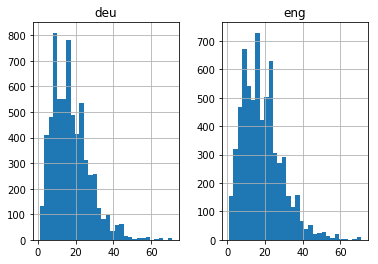

In [14]:
# empty lists 
eng_l = [] 
deu_l = [] 

# populate the lists with sentence lengths 
for i in deu_eng[:,0]: 
      eng_l.append(len(i.split())) 

for i in deu_eng[:,1]: 
      deu_l.append(len(i.split())) 

length_df = pd.DataFrame({'eng':eng_l, 'deu':deu_l})
length_df.hist(bins = 30) 
plt.show()

the maximum length of the German sentences is of max. range of 68 and that of the English phrases is 68. But, their graph pattern is different from each other

### 3.3)-vectorize our text data 

by using Keras’s Tokenizer()

In [15]:
# function to build a tokenizer 
def tokenization(lines): 
      tokenizer = Tokenizer() 
      tokenizer.fit_on_texts(lines) 
      return tokenizer

# prepare english tokenizer 
eng_tokenizer = tokenization(deu_eng[:, 0]) 
eng_vocab_size = len(eng_tokenizer.word_index) + 1 
eng_length = 8 

print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 7231


In [16]:
# prepare Deutch tokenizer 
deu_tokenizer = tokenization(deu_eng[:, 1]) 
deu_vocab_size = len(deu_tokenizer.word_index) + 1 
deu_length = 8 
print('Deutch Vocabulary Size: %d' % deu_vocab_size)

Deutch Vocabulary Size: 9284


There is difference in amount of words in two languages.We need to encode sequence

### 3.4)-encode and pad sequences 

In [0]:
def encode_sequences(tokenizer, length, lines):          
         # integer encode sequences          
         seq = tokenizer.texts_to_sequences(lines)          
         # pad sequences with 0 values          
         seq = pad_sequences(seq, maxlen=length, padding='post')           
         return seq

# 4)-Model Building

### 4.1)- Train-test Split

80%-20%

In [0]:
from sklearn.model_selection import train_test_split 

# split data into train and test set 
train,test= train_test_split(deu_eng,test_size=0.2,random_state= 12)

### 4.2)- Defining input and target
We will encode English sentences as the input sequences and German sentences as the target sequences

In [19]:
# english version
train[:, 0]

array(['its not my responsibility',
       'meanwhile in our homes items as innocuous as floor tiles or shed roofs have routinely contained asbestos',
       'she said i keep thinking this world did not get better within these years',
       ...,
       'crops are rotting in the fields mines have been deserted and the markets have been abandoned the virus has cost the region dearly',
       'the preparations for the party are well underway in tannenwald gun club which will celebrate years since being established on to september',
       'it also means higher taxes'], dtype='<U511')

In [20]:
# english version
train[:, 1]

array(['ich bin nicht dafur verantwortlich',
       'und derweil haben so unschuldige gegenstande in unseren hausern wie fubodenplatten oder schuppendacher standardmaig asbest enthalten',
       'sie sagte ich denke immer dass diese welt in diesen jahren nicht besser geworden ist',
       ...,
       'die ernte verrottet auf den feldern die minen sind verlassen und die markte verwaist das virus hat der region schwer zugesetzt',
       'auf hochtouren laufen beim schutzenverein tannenwald die vorbereitungen fur das grundungsfest von bis september',
       'sie bedeutet auch hohere steuern'], dtype='<U511')

In [0]:
# prepare training data 
trainX = encode_sequences(eng_tokenizer, deu_length, train[:, 0]) 
trainY = encode_sequences(deu_tokenizer, eng_length, train[:, 1]) 

# prepare validation data 
testX = encode_sequences(eng_tokenizer, deu_length, test[:, 0]) 
testY = encode_sequences(deu_tokenizer, eng_length, test[:, 1])

In [22]:
print(trainX[:5])

[[  48   23   51 4075    0    0    0    0]
 [2904   64 2016 5284   17 5285 2943   65]
 [ 141   97   23   98  179  362  193   58]
 [  69  610  427   23 1523 1892 2202 5445]
 [1329    3  113   76    1  204 3174    4]]


In [23]:
print(trainY[:5])

[[  15  184   18  272 1521    0    0    0]
 [1071   30 2751   59 6215 6216   85 1223]
 [ 197    4  261  100   18  323  708   16]
 [6478   55 1233  208 6479 6480  956 1466]
 [ 264    5  550    6    4  592    6  180]]


In [24]:
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(5205, 8)
(5205, 8)
(1302, 8)
(1302, 8)


### 4.3)- build NMT model

In [25]:
eng_length

8

In [26]:
deu_length

8

In [0]:
 def build_model(in_vocab,out_vocab, in_timesteps,out_timesteps,n):   
      model = Sequential() 
      model.add(Embedding(in_vocab, n, input_length=in_timesteps,   
      mask_zero=True)) 
      model.add(LSTM(n)) 
      model.add(RepeatVector(out_timesteps)) 
      model.add(LSTM(n, return_sequences=True))  
      model.add(Dense(out_vocab, activation='softmax')) 
      return model

In [28]:
# model compilation (with 512 hidden units)
model = build_model(eng_vocab_size,deu_vocab_size, eng_length, deu_length, 512)

rms = optimizers.RMSprop(lr=0.001) 
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




In [29]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 8, 512)            3702272   
_________________________________________________________________
lstm_1 (LSTM)                (None, 512)               2099200   
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 8, 512)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 8, 512)            2099200   
_________________________________________________________________
dense_1 (Dense)              (None, 8, 9284)           4762692   
Total params: 12,663,364
Trainable params: 12,663,364
Non-trainable params: 0
_________________________________________________________________


In [30]:
filename = 'model_translate.h1' 

# set checkpoint
checkpoint = ModelCheckpoint(filename, monitor='val_loss',  
                             verbose=1, save_best_only=True, 
                             mode='min') 


# train model 
history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), 
                    epochs=30, batch_size=512, validation_split = 0.2, 
                    callbacks=[checkpoint], verbose=1)


Train on 4164 samples, validate on 1041 samples
Epoch 1/30
4164/4164 [==============================] - 8s 2ms/step - loss: 8.2239 - val_loss: 7.3432

Epoch 00001: val_loss improved from inf to 7.34316, saving model to model_translate.h1
Epoch 2/30
4164/4164 [==============================] - 2s 546us/step - loss: 7.0973 - val_loss: 7.2177

Epoch 00002: val_loss improved from 7.34316 to 7.21767, saving model to model_translate.h1
Epoch 3/30
4164/4164 [==============================] - 2s 548us/step - loss: 6.9842 - val_loss: 7.1847

Epoch 00003: val_loss improved from 7.21767 to 7.18468, saving model to model_translate.h1
Epoch 4/30
4164/4164 [==============================] - 2s 548us/step - loss: 6.9288 - val_loss: 7.1315

Epoch 00004: val_loss improved from 7.18468 to 7.13151, saving model to model_translate.h1
Epoch 5/30
4164/4164 [==============================] - 2s 548us/step - loss: 6.8462 - val_loss: 7.1350

Epoch 00005: val_loss did not improve from 7.13151
Epoch 6/30
4164/4

# 5)-Plotting results

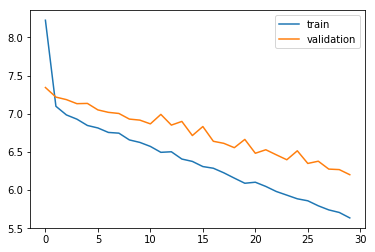

In [31]:
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss']) 
plt.legend(['train','validation']) 
plt.show()

As you can see in the above plot, the validation loss stopped decreasing after 5 epochs. It did improve but not very significant.So, we didn't get very good results from our basic model.

# 6)-Make Predictions

In [0]:
model = load_model('model_translate.h1') 

preds = model.predict_classes(testX.reshape((testX.shape[0], testX.shape[1])))

These predictions are sequences of integers. We need to convert these integers to their corresponding words.

### 6.1)- Convert integers to words

In [0]:
def get_word(n, tokenizer):  
      for word, index in tokenizer.word_index.items():                       
          if index == n: 
              return word 
      return None

### 6.2)-Convert predictions into text (German)

In [0]:
preds_text = [] 
for i in preds:        
       temp = []        
       for j in range(len(i)):             
            t = get_word(i[j], deu_tokenizer)             
            if j > 0:                 
                if (t==get_word(i[j-1],deu_tokenizer))or(t== None):                       
                     temp.append('')                 
                else:                      
                     temp.append(t)             
            else:                    
                if(t == None):                                   
                     temp.append('')                    
                else:                           
                     temp.append(t)        
       preds_text.append(' '.join(temp))

In [0]:
pred_df = pd.DataFrame({'actual' : test[:,1], 'predicted' : preds_text})

In [36]:
# 1st 5 rows
pred_df.head(5)

,actual,predicted
0,wahrend die konkurrenz naher ruckt und neue technologien alte bequeme sicherheiten bedrohen ist die anstehende verhandlung der lizenzgebuhren fur die bbc mit besonderen gefahren verbunden,und die der zu
1,luther rabinowitz lie seine pyramide zusammenfallen,ich war in ein fur
2,kurzlich erklarten die gesundheitsbehorden die krankheit sei in jeden winkel des landes vorgedrungen,und die und der zu war
3,ich billige den tweet nicht und habe ihn geloscht hie es in der spateren nachricht,und war
4,fur den chef des oberurseler kultkiosks gehoren radtouren uber den feldberg einfach dazu,und die und der zu


In [37]:
# print 5 rows randomly 
pred_df.sample(5)

,actual,predicted
751,dass es auch ohne rad locker nach oben ging bewiesen nicht nur die wanderer die uber die weie mauer und den fuchstanz zum gipfel hinauf stiegen sondern auch ein jogger der an einer kordel einen au...,und der war
1164,ich wollte fur mein land kampfen aber das wird nicht geschehen,ich nicht
853,es ist so schwierig sich an alle orte zu erinnern an denen man gearbeitet hat und an die daten,und die und zu war
816,pascal perrineau ein politikwissenschaftler an der sciences po universitat warnte davor dass die franzosen schnell die geduld verlieren wurde wenn die neue sozialistische regierung keine verbesser...,und die und der zu wurde
408,ich hoffe dass frauen die einen anderen aber parallelen grund dafur haben eine dem korper innewohnende gefahr zu verstehen und meinungen zur rasse die in offentlichen umfragen deutlich anders sind...,und die und der zu wurde
